# Imports

In [1]:
# Import necessary libraries for mathematical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# Import astropy modules for working with astronomical data
import astropy.units as u
from astropy.visualization import simple_norm, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import angular_separation, Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.nddata import Cutout2D
# Import os for directory operations
import os
# Import astroalign for aligning astronomical images
import astroalign as align
# Import twirl for peak finding and WCS (World Coordinate System) computations
from twirl import find_peaks
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs
# Import photutils for aperture photometry
from photutils.aperture import SkyCircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from pylab import figure, cm
# Import pandas for data manipulation
import pandas as pd

import random

In [2]:
#Constnats
# BLUE_FILTER_COLOR =  'Blues'
# RED_FILTER_COLOR =  'Reds'

BLUE_FILTER_COLOR =  cm.grey
RED_FILTER_COLOR =  cm.grey

# Target

In [3]:
DIRECTORY="m2/"
# DIRECTORY="m13/"

# Gather all the files

In [4]:
#Get the file directory

# Define the directories where the FITS files are stored
directory_b_filter = DIRECTORY + "Light_B.fits"
directory_r_filter = DIRECTORY + "Light_R.fits"

# Load the FITS files into variables
b_filter_fits = fits.open(directory_b_filter)
r_filter_fits = fits.open(directory_r_filter)


# Use twirl to find peaks

In [ ]:
peak_location_b_filter = find_peaks(b_filter_fits.data)[0:20]
peak_location_r_filter = find_peaks(r_filter_fits.data)[0:20]


# display the peaks

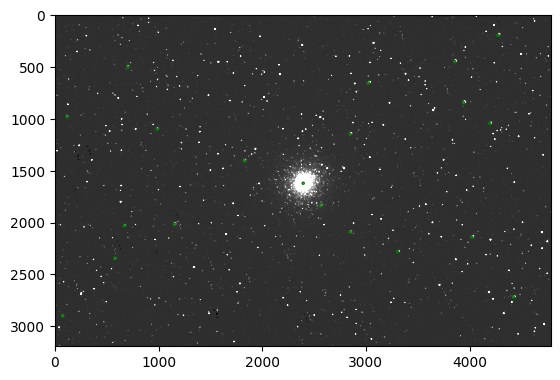

In [ ]:

plt.imshow(b_filter_fits.data, vmin = 0.1 * np.median(b_filter_fits.data), vmax = 5 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(peak_location_b_filter, r = 10.0).plot(color="g")

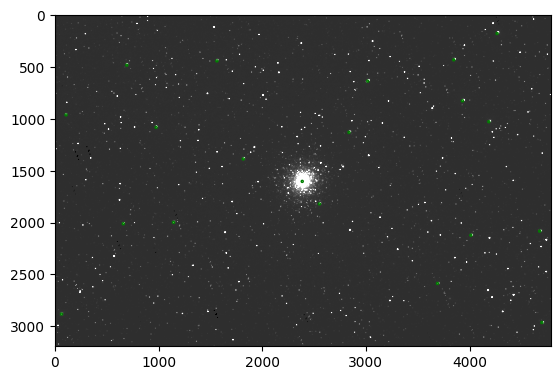

In [ ]:
plt.imshow(r_filter_fits.data, vmin = 0.1 * np.median(r_filter_fits.data), vmax = 5 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
_ = CircularAperture(peak_location_r_filter, r = 10.0).plot(color="g")

# Obtain and filter RA/DEC coordinates from the Gaia catalog

In [ ]:
all_radecs_b_filter = gaia_radecs((b_filter_fits.header['RA'], b_filter_fits.header['DEC']), 1.2 * 0.65)
all_radecs_r_filter = gaia_radecs((r_filter_fits.header['RA'], r_filter_fits.header['DEC']), 1.2 * 0.65)

# we only keep stars 0.01 degree apart from each other
thrushold           = 0.01 # degrees
all_radecs_b_filter = sparsify(all_radecs_b_filter, thrushold)
all_radecs_r_filter = sparsify(all_radecs_r_filter, thrushold)

# Map WCS coordinates to image coordinate

In [ ]:
# we only keep the 30 brightest stars from gaia
wcs_b_filter = compute_wcs(peak_location_b_filter, all_radecs_b_filter[0:30], tolerance = 10)
wcs_r_filter = compute_wcs(peak_location_r_filter, all_radecs_r_filter[0:30], tolerance = 10)

# Plot the detected sources

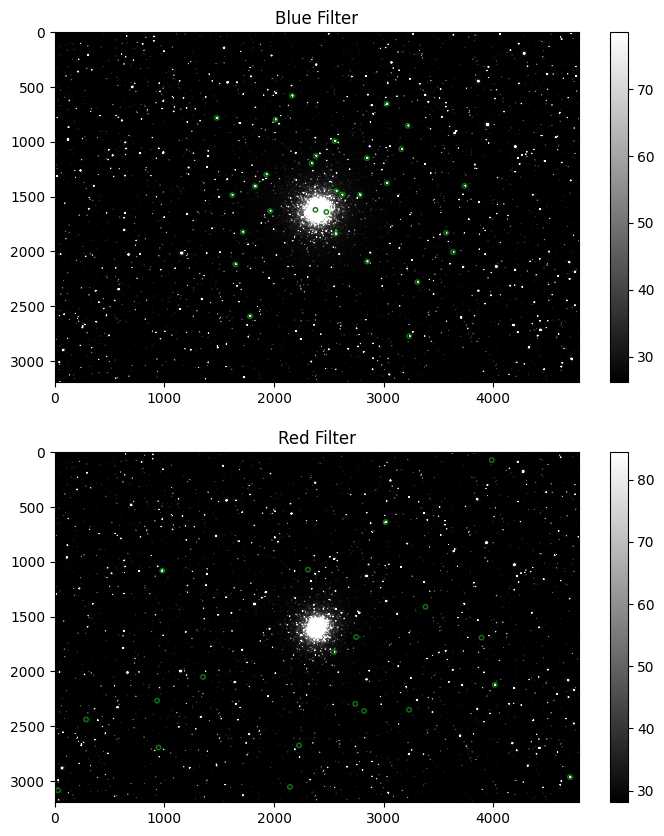

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the combined graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Blue filter plot (top)
radecs_location_b_fiter = np.array(wcs_b_filter.world_to_pixel_values(all_radecs_b_filter))
im1 = ax1.imshow(b_filter_fits.data, vmin= np.median(b_filter_fits.data), vmax= 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
CircularAperture(radecs_location_b_fiter[0:30], 20).plot(color = "g", ax = ax1)
ax1.set_title('Blue Filter')

# Red filter plot (bottom)
radecs_locations_r_filter = np.array(wcs_r_filter.world_to_pixel_values(all_radecs_r_filter))
im2 = ax2.imshow(r_filter_fits.data, vmin = np.median(r_filter_fits.data), vmax = 3 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
CircularAperture(radecs_locations_r_filter[0:30], 20).plot(color = "g", ax = ax2)
ax2.set_title('Red Filter')

# Add colorbars
fig.colorbar(im1, ax = ax1, orientation = 'vertical', fraction = 0.046, pad = 0.04)
fig.colorbar(im2, ax = ax2, orientation = 'vertical', fraction = 0.046, pad = 0.04)

# Save the combined plot
plt.savefig(DIRECTORY + "Gaia Catalog Star.jpg")

plt.show()
plt.clf()


# Update Header for the lights with the new WCS

In [ ]:
b_filter_fits.header.update(wcs_b_filter.to_header())
r_filter_fits.header.update(wcs_r_filter.to_header())

# Normalize the lights

In [ ]:
b_filter_fits.data = b_filter_fits.data/(16*120.0)
r_filter_fits.data = r_filter_fits.data/(16*120.0)

# Get the co-orditane of M2 stars and their brightness from Database
#### used CANFAR's Stetson Database

In [5]:
# load the data from memory
coords = pd.read_csv( DIRECTORY + "NGC7089.pos", sep='[ ]{2,}', engine='python') # replace anything w 2 or more spaces with just a space
mags = pd.read_csv(DIRECTORY + "NGC7089.pho", sep='[ ]{1,}', engine='python') # replace anything w 1 or more spaces with just a space



# Let's extract what we need from the stetson database

In [6]:
# add coloum names to the coordinate file
coords.rename(columns={'323.36209232807' : 'RA', '-00.84555554920' : 'DEC'}, inplace=True) # replace the orgonal col names for somethig meaningfull

# Convert the DEC column to string type first
coords['DEC'] = coords['DEC'].astype(str)

# Now you can use the .str accessor to replace spaces
coords['DEC'] = coords['DEC'].str.replace(" ", "")

# Convert the DEC column back to float type
coords['DEC'] = coords['DEC'].astype(float)

# Perform the merge with the photometry data
stetson = pd.merge(coords[["Reference", 'RA', 'DEC']], mags[["Reference", 'B', 'sigma.1', 'R', 'sigma.3']], how='inner', on=['Reference'])

# Filter the stars with magnitude of 18 or brighter
stetson = stetson[(stetson.B < 19) & (stetson.R < 19)]

stetson_b_filter = stetson[["Reference", 'RA', 'DEC', 'B', 'sigma.1']]
stetson_r_filter = stetson[["Reference", 'RA', 'DEC', 'R', 'sigma.3']]


# Lets plot what we extracted

In [7]:
stetson_pos_b_filter = np.array(wcs_b_filter.world_to_pixel_values( stetson_b_filter[["RA", "DEC"]] ))
stetson_pos_r_filter = np.array(wcs_r_filter.world_to_pixel_values( stetson_r_filter[["RA", "DEC"]] ))

NameError: name 'wcs_b_filter' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Blue filter plot
ax1 = plt.subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_fits.data, vmin = np.median(b_filter_fits.data), vmax = 3 * np.median(b_filter_fits.data), cmap = BLUE_FILTER_COLOR)
_ = CircularAperture(stetson_pos_b_filter, 10).plot(color = "g", alpha = 0.5)
ax1.set_title('Blue Filter')

# Blue filter plot
ax2 = plt.subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_fits.data, vmin = np.median(r_filter_fits.data), vmax = 3 * np.median(r_filter_fits.data), cmap = RED_FILTER_COLOR)
_ = CircularAperture(stetson_pos_r_filter, 10).plot(color = "g", alpha = 0.5)
ax2.set_title('Red Filter')


plt.show()
plt.savefig(DIRECTORY + "Steton Catalog Stars.jpg")
plt.clf()

# Lets define & Work with a small subsection
#### FOV too large

In [ ]:
position = (2200, 1000)
size = (1000, 1000)
cutout_b_filter = Cutout2D(b_filter_fits.data, position, size, wcs = wcs_b_filter)
cutout_r_filter = Cutout2D(r_filter_fits.data, position, size, wcs = wcs_r_filter)


In [ ]:
#make 2 empyth fits files
b_filter_analysis = fits.PrimaryHDU()
r_filter_analysis = fits.PrimaryHDU()

#point them to the cutout data
b_filter_analysis.data = cutout_b_filter.data
r_filter_analysis.data = cutout_r_filter.data

b_filter_analysis.header.update(cutout_b_filter.wcs.to_header())
r_filter_analysis.header.update(cutout_r_filter.wcs.to_header())


In [ ]:
#compute wcs for this cutout
peaks_b_filter = find_peaks(b_filter_analysis.data)[0:20]
wcs_cutout_b_filter = compute_wcs(peaks_b_filter, all_radecs_b_filter[0:30], tolerance = 10)
stetson_pos_b_filter = np.array(wcs_cutout_b_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


peaks_r_filter = find_peaks(r_filter_analysis.data)[0:20]
wcs_cutout_r_filter = compute_wcs(peaks_r_filter, all_radecs_r_filter[0:30], tolerance = 10)
stetson_pos_r_filter = np.array(wcs_cutout_r_filter.world_to_pixel_values(stetson[["RA", "DEC"]]))


In [ ]:
# Create a new figure
fig = plt.figure(figsize=(10, 8))

# Blue filter plot on top
ax1 = fig.add_subplot(2, 1, 1, projection = wcs_b_filter)
ax1.imshow(b_filter_analysis.data, vmin=np.median(b_filter_fits.data), vmax=3 * np.median(b_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_b_filter, 10).plot(ax=ax1, color="m", alpha=0.5)
ax1.set_title('Blue Filter')

# Red filter plot on bottom
ax2 = fig.add_subplot(2, 1, 2, projection = wcs_r_filter)
ax2.imshow(r_filter_analysis.data, vmin=np.median(r_filter_fits.data), vmax=3 * np.median(r_filter_fits.data), cmap="Greys_r")
CircularAperture(stetson_pos_r_filter, 10).plot(ax=ax2, color="m", alpha=0.5)
ax2.set_title('Red Filter')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig(DIRECTORY + "TWIRL peaks in curout.jpg")
